In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
df = pd.read_csv("food_choices.csv")
selected_columns = ['comfort_food', 'comfort_food_reasons', 'comfort_food_reasons_coded', 'Gender']
df = df[selected_columns]

In [24]:
df['comfort_food'].fillna('unknown', inplace=True)
mode_coded = df['comfort_food_reasons_coded'].mode()[0]
df['comfort_food_reasons_coded'].fillna(mode_coded, inplace=True)
df['Gender'].fillna('Unknown', inplace=True)

missing_values = df.isnull().sum()
print("Missing values after handling:\n", missing_values)

Missing values after handling:
 comfort_food                  0
comfort_food_reasons          1
comfort_food_reasons_coded    0
Gender                        0
dtype: int64


In [25]:
def categorize_food(food):
    food = food.lower()
    if any(keyword in food for keyword in ['fruit', 'vegetable', 'grapes', 'carrots', 'broccoli', 'tomato soup', 'spaghetti squash', 'carrots', 'plantain chips', 'almonds', 'watermelon', 'cucumber', 'fritos']):
        return 'Fruit and Vegetables'
    elif any(keyword in food for keyword in ['pizza', 'pasta', 'spaghetti', 'noodles', 'rice', 'potatoes', 'bagels', 'fries', 'taco', 'sandwich', 'hot dog', 'burrito', 'sub', 'macaroni and cheese', 'lasagna', 'mashed potatoes', 'spaghetti squash', 'stuffed peppers', 'meatball sub', 'chicken tikka masala', 'chicken noodle soup', 'chicken pot pie']):
        return 'Starchy food'
    elif any(keyword in food for keyword in ['milk', 'cheese', 'yogurt', 'ice cream', 'mozzarella sticks', 'cottage cheese', 'cheesecake', 'frozen yogurt']):
        return 'Dairy'
    elif any(keyword in food for keyword in ['chicken', 'beef', 'pork', 'fish', 'egg', 'turkey', 'meatball', 'sausage', 'fried chicken', 'grilled chicken', 'chicken fingers', 'beef jerky', 'steak']):
        return 'Protein'
    elif any(keyword in food for keyword in ['chips', 'fries', 'chocolate', 'cake', 'cookie', 'brownie', 'candy', 'soda', 'donut', 'peanut butter', 'burgers', 'garlic bread', 'popcorn', 'pretzels', 'chicken wings', 'doughnut', 'chocolate bar', 'twizzlers', 'chocolate brownie', 'macaroons', 'truffles', 'french fries', 'slim jims', 'chicken curry', 'chocolate chipotle', 'pop', 'mac n cheese', 'rice', 'pizza', 'cheeseburger', 'chicken nuggets', 'peanut butter sandwich', 'mac and cheese', 'cheese and crackers', 'protein bar', 'chex mix', 'cheez-its', 'chicken fingers', 'chips and cheese', 'chips and dip', 'fruit snacks', 'doritos']):
        return 'Fat'
    else:
        return 'Others'

In [26]:
df['food_group'] = df['comfort_food'].apply(categorize_food)

# One-hot encode categorical variables
ohe = OneHotEncoder()
encoded_features = ohe.fit_transform(df[['Gender', 'food_group']]).toarray()

In [27]:
def map_reasons_to_mood_code(code):
    mapping = {
        1: 'stress/anxiety',
        2: 'boredom',
        3: 'sadness',
        4: 'happiness/celebration',
        5: 'other',
        9: 'unknown'
    }
    return mapping.get(code, 'unknown')

In [28]:
df['mood_category'] = df['comfort_food_reasons_coded'].apply(map_reasons_to_mood_code)


In [29]:
X = encoded_features
y = df['mood_category']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

In [32]:
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear']
}

In [44]:
classifiers = {
    "LogisticRegression": GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5),
    "GradientBoosting": GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5)
}
df

,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,Gender,food_group,mood_category
0,none,we dont have comfort,9.0,Male,Others,unknown
1,"chocolate, chips, ice cream","Stress, bored, anger",1.0,Female,Dairy,stress/anxiety
2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,Female,Starchy food,stress/anxiety
3,"Pizza, Mac and cheese, ice cream",Boredom,2.0,Female,Starchy food,boredom
4,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,Female,Dairy,stress/anxiety
5,"Candy, brownies and soda.","None, i don't eat comfort food. I just eat whe...",4.0,Female,Fat,happiness/celebration
6,"Chocolate, ice cream, french fries, pretzels","stress, boredom",1.0,Male,Starchy food,stress/anxiety
7,"Ice cream, cheeseburgers, chips.",I eat comfort food when im stressed out from s...,1.0,Female,Dairy,stress/anxiety
8,"Donuts, ice cream, chips",Boredom,2.0,Female,Dairy,boredom
9,"Mac and cheese, chocolate, and pasta","Stress, anger and sadness",1.0,Female,Starchy food,stress/anxiety


In [45]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {name}:\n", report)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}\n")

    # Save the trained model
    model_filename = f"{name}_model.pkl"
    joblib.dump(clf, model_filename)
    print(f"Saved {name} model to {model_filename}")

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classifica

Classification Report for LogisticRegression:
                 precision    recall  f1-score   support

       boredom       0.68      1.00      0.81        17
       sadness       0.00      0.00      0.00         2
stress/anxiety       0.00      0.00      0.00         4
       unknown       0.00      0.00      0.00         2

      accuracy                           0.68        25
     macro avg       0.17      0.25      0.20        25
  weighted avg       0.46      0.68      0.55        25

Accuracy for LogisticRegression: 0.68

Saved LogisticRegression model to LogisticRegression_model.pkl
Classification Report for GradientBoosting:
                        precision    recall  f1-score   support

              boredom       0.65      0.65      0.65        17
happiness/celebration       0.00      0.00      0.00         0
              sadness       0.00      0.00      0.00         2
       stress/anxiety       0.00      0.00      0.00         4
              unknown       0.00      0

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

In [35]:
training_artifacts = {
    "one_hot_encoder": ohe,
    "models": classifiers
}

In [36]:
joblib.dump(training_artifacts, "training_artifacts.joblib")
print("Training artifacts saved")

Training artifacts saved


In [37]:
comfort_food_reasons_text = df['comfort_food_reasons'].astype(str).values

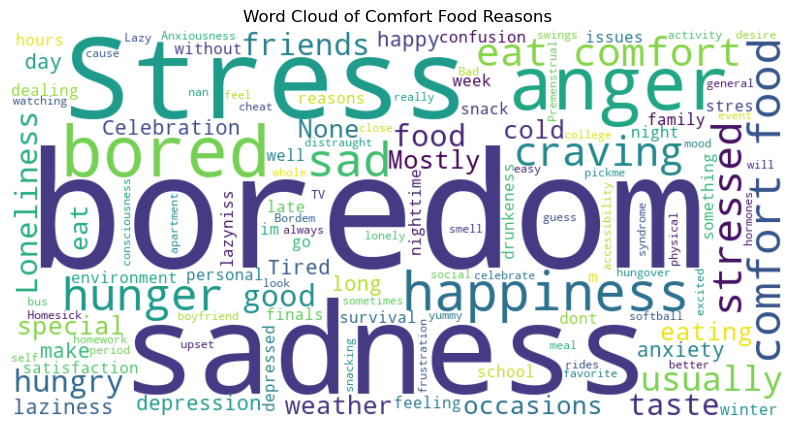

In [38]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(comfort_food_reasons_text))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Comfort Food Reasons')
plt.axis('off')
plt.show()

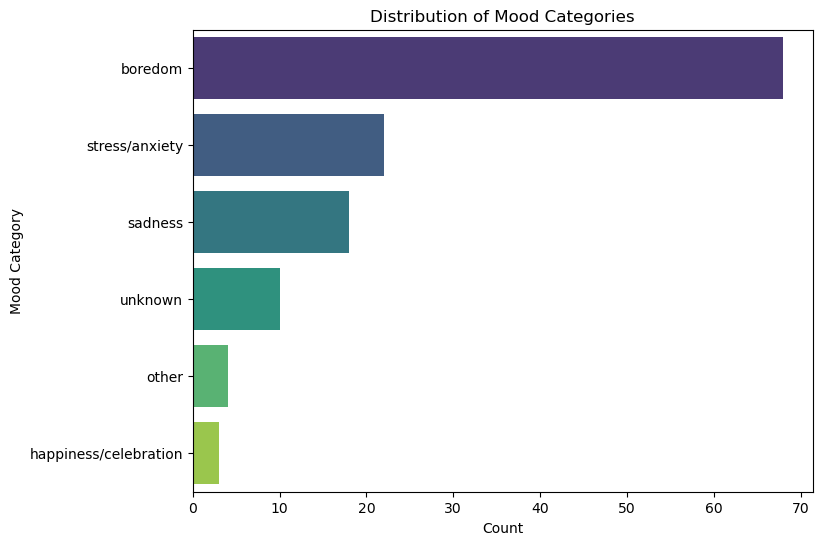

In [39]:
df_exploded = df.explode('mood_category')
plt.figure(figsize=(8, 6))
sns.countplot(y='mood_category', data=df_exploded, order=df_exploded['mood_category'].value_counts().index, palette='viridis')
plt.title('Distribution of Mood Categories')
plt.xlabel('Count')
plt.ylabel('Mood Category')
plt.show()


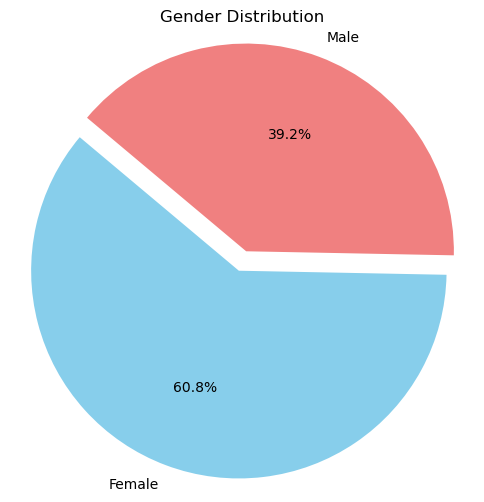

In [40]:
gender_mapping = {1: 'Female', 2: 'Male'}
df['Gender'] = df['Gender'].map(gender_mapping)

plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], explode=(0.1, 0), startangle=140)
plt.title('Gender Distribution')
plt.ylabel('')
plt.axis('equal')
plt.show()

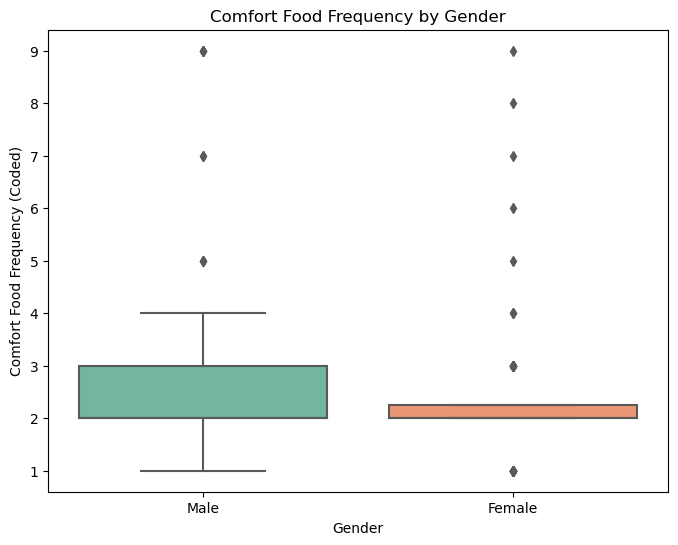

In [41]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='comfort_food_reasons_coded', data=df, palette='Set2')
plt.title('Comfort Food Frequency by Gender')
plt.xlabel('Gender')
plt.ylabel('Comfort Food Frequency (Coded)')
plt.show()

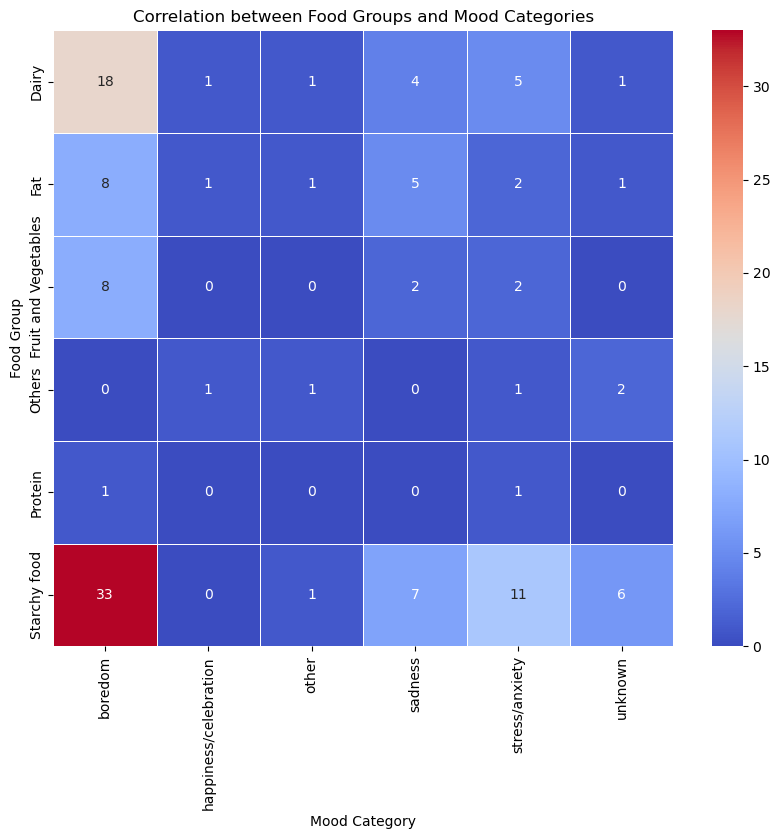

In [42]:
correlation_matrix = df_exploded.groupby(['food_group', 'mood_category']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='d', linewidths=0.5)
plt.title('Correlation between Food Groups and Mood Categories')
plt.xlabel('Mood Category')
plt.ylabel('Food Group')
plt.show()


In [43]:
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5)
    print(f"Cross-Validation Scores for {name}: {scores}")
    print(f"Mean Cross-Validation Score for {name}: {scores.mean()}\n")

C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least

Cross-Validation Scores for LogisticRegression: [0.52 0.52 0.56 0.56 0.56]
Mean Cross-Validation Score for LogisticRegression: 0.544



C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Windows 10\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least

Cross-Validation Scores for GradientBoosting: [0.52 0.52 0.48 0.52 0.52]
Mean Cross-Validation Score for GradientBoosting: 0.512

